# Premier workflow d'identication d'un champignon
Utilisation d'un générateur d'images  
Fichiers en local sur le HDD  
Utilisation d'un modèle pré-entrainé VGG16

Pour ce test, nous avons sélectionné les champignons suivants:
"Agaricaceae", "Amanitaceae", "Fomitopsidaceae", "Polyporaceae"  
Voici le lien pour télécharger les images : https://drive.google.com/file/d/1uYXilekd5IxCornaRyFlWmzpyJb-txSi/view?usp=sharing  
Puis dézipper le fichier au même niveau que le notebook, de sorte que le notebook et le répertoire Images soient au même niveau

Nous prévoyons de dupliquer ce Notebook pour comparer les performances entre "flow_from_directory" et "flow_from_dataframe"

Nous avons passé beaucoup de temps pour utiliser la fonction "predict", le problème étant sur le format d'image attendu. Nous avons testé 2 méthodes, dont "preprocess_input" qui nous a causé des misères


In [3]:
import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [3]:


import pandas as pd
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Model 
import matplotlib.pyplot as plt


## Compilation du répertoire principal et du chemin relatif de chaque image
Notre jeu de donné est séparé en deux dossiers : train et test

In [8]:
import pathlib
#from sklearn.model_selection import train_test_split
df = pd.read_csv ("allpath.csv")
base_dir = 'D:/champiseed'
df["path"] = base_dir+df["path"]
#data_train, data_test = train_test_split(data, test_size=0.2, random_state=123)
df["isweetgum"]=df["identifier_y"].apply(lambda x: "sweetgum.nybg.org" in x)
df = df[df["isweetgum"]== False]

In [9]:
sample_per_classe = 4000

sub_c1 = df[df["genus"] == "Paxillus"].sample(sample_per_classe)
sub_c2 = df[df["genus"] == "Clathrus"].sample(sample_per_classe)
sub_c3 = df[df["genus"] == "Geastrum"].sample(sample_per_classe)
sub_c4 = df[df["genus"] == "Scleroderma"].sample(sample_per_classe)
sub_c5 = df[df["genus"] == "Byssomerulius"].sample(sample_per_classe)
sub_c6 = df[df["genus"] == "Phaeolus"].sample(sample_per_classe)
sub_c7 = df[df["genus"] == "Agaricus"].sample(sample_per_classe)
sub_c8 = df[df["genus"] == "Amanita"].sample(sample_per_classe)
sub_c9 = df[df["genus"] == "Auricularia"].sample(sample_per_classe)
sub_c10 = df[df["genus"] == "Craterellus"].sample(sample_per_classe)

data = pd.concat([sub_c1, sub_c2, sub_c3, sub_c4, sub_c5, sub_c6, sub_c7, sub_c8, sub_c9, sub_c10])

data

,Unnamed: 0,Unnamed: 0.1,id,identifier_y,kingdom,phylum,class,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,isweetgum
2281251,2281251,2432129,1957081831,https://observation.org/photos/4049797.jpg,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,NL,52.400000,6.650000,True,D:/champiseed/Boletales/Paxillaceae/Paxillus/P...,False
650609,650609,680328,2843302910,https://observation.org/photos/23619613.jpg,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,NL,52.650000,4.600000,True,D:/champiseed/Boletales/Paxillaceae/Paxillus/P...,False
446413,446413,468096,1972186111,https://observation.org/photos/12229565.jpg,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,NL,51.500000,4.850000,True,D:/champiseed/Boletales/Paxillaceae/Paxillus/P...,False
1070576,1070576,1128376,1975977358,https://observation.org/photos/9508544.jpg,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,NL,53.050000,6.200000,True,D:/champiseed/Boletales/Paxillaceae/Paxillus/P...,False
2047669,2047669,2184814,2864861517,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,RU,55.535217,37.593809,True,D:/champiseed/Boletales/Paxillaceae/Paxillus/P...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759554,759554,794599,2423323515,https://www.artsobservasjoner.no/MediaLibrary/...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus tubaeformis,Craterellus tubaeformis,NO,58.732546,8.301655,True,D:/champiseed/Cantharellales/Cantharellaceae/C...,False
1678816,1678816,1786602,2866933400,https://www.artsobservasjoner.no/MediaLibrary/...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus tubaeformis,Craterellus tubaeformis,NO,59.383492,9.300402,True,D:/champiseed/Cantharellales/Cantharellaceae/C...,False
2202276,2202276,2350129,1946456897,https://www.artsobservasjoner.no/MediaLibrary/...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus tubaeformis,Craterellus tubaeformis,NO,69.914317,23.465289,True,D:/champiseed/Cantharellales/Cantharellaceae/C...,False
2114369,2114369,2256161,2238571153,https://svampe.databasen.org/uploads/2018-9342...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus tubaeformis,Craterellus tubaeformis (Bull.) Quél.,DK,56.010283,12.292998,True,D:/champiseed/Cantharellales/Cantharellaceae/C...,False


# test d'importation sur une image

In [5]:
data['path'].iloc[54970]

'D:/champiseed/Agaricales/Porotheleaceae/Porotheleum/Porotheleum fimbriatum/im54970.jpg'

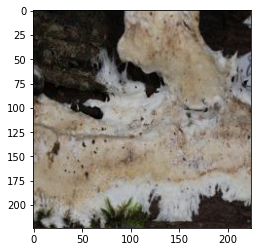

In [6]:
from PIL import Image 
%matplotlib inline
  
# creating a object 
im = Image.open(data["path"].iloc[54970]) 
  
plt.imshow(im)

## Générateur d'image
On met rotation_range à 180 pour générer des images dans tous les sens, ce qui devrait permettre d'éviter le flip (à valider)  


In [ ]:
batch_size = 1024

from tensorflow.keras.applications.inception_v3 import preprocess_input

# Parametres du générateur d'images pour l'entrainement
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 180,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = [0.9,1.1],
                                   horizontal_flip = False,
                                   validation_split=0.2)

# Générateur d'images pour le test
#test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(dataframe=data,
                                                          directory="",
                                                           x_col = "path",
                                                           class_mode ="sparse",
                                                          y_col = "family",
                                                          target_size = (224 , 224), 
                                                          batch_size = batch_size,
                                                          subset='training')

test_generator = train_datagen.flow_from_dataframe(dataframe=data,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col = "family",
                                                           class_mode ="sparse",
                                                          target_size = (224 , 224), 
                                                          batch_size = batch_size,
                                                          subset='validation')

In [6]:
train_generator.samples

63988

In [16]:
from PIL import Image
tab = train_generator.filenames
for i in tab:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)

In [17]:
tab1 = test_generator.filenames
for i in tab1:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)

## Création du modèle inception

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(input_shape=(224,224,3),
                       weights="imagenet",
                       include_top=False
                       )

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D


for layer in inception.layers:
    layer.trainable = False

model = Sequential()
model.add(inception)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 64, activation = 'softmax'))
    
model.compile(optimizer = "adam",
             loss = 'sparse_categorical_crossentropy',
             metrics = ["acc"])

## Entrainement

In [11]:
from PIL import Image

incepmodel = model.fit(train_generator, validation_data = test_generator, steps_per_epoch = train_generator.samples//batch_size, epochs = 10)

Epoch 1/10
62/62 [==============================] - 1073s 17s/step - loss: 2.3125 - acc: 0.3173 - val_loss: 2.6330 - val_acc: 0.2266
Epoch 2/10
62/62 [==============================] - 1071s 17s/step - loss: 2.2446 - acc: 0.3349 - val_loss: 2.6049 - val_acc: 0.2408
Epoch 3/10
62/62 [==============================] - 1078s 17s/step - loss: 2.2007 - acc: 0.3451 - val_loss: 2.5997 - val_acc: 0.2389
Epoch 4/10
62/62 [==============================] - 1081s 17s/step - loss: 2.1689 - acc: 0.3542 - val_loss: 2.5694 - val_acc: 0.2485
Epoch 5/10
62/62 [==============================] - 1089s 17s/step - loss: 2.1444 - acc: 0.3621 - val_loss: 2.5652 - val_acc: 0.2496
Epoch 6/10
62/62 [==============================] - 1103s 18s/step - loss: 2.1225 - acc: 0.3684 - val_loss: 2.5505 - val_acc: 0.2564
Epoch 7/10
62/62 [==============================] - 1101s 18s/step - loss: 2.1071 - acc: 0.3718 - val_loss: 2.5454 - val_acc: 0.2539
Epoch 8/10
62/62 [==============================] - 1104s 18s/step - 

In [ ]:
incepmodel.summary()

## Graphique montrant l'évolution de la précision et la perte en fonction des epochs
On note un surapprentissage, la précision sur le test set étant significativement plus faible que sur le train set

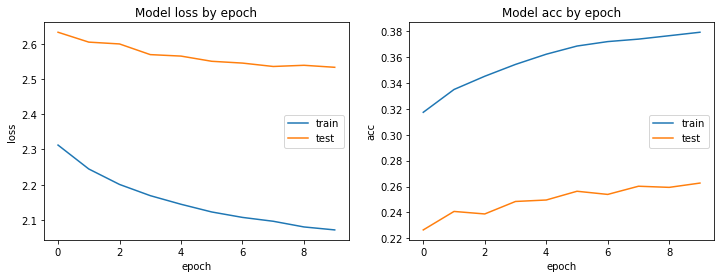

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(incepmodel.history['loss'])
plt.plot(incepmodel.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(incepmodel.history['acc'])
plt.plot(incepmodel.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


## Test prédictions 
A noter que la famille "Polyporaceae" et "Fomitopsidaceae" sont assz proches (gros parasite sur les tronc)

Nous avons d'abord utilisé le preprocess suivant avant d'appeler model.predict(img) :  
img = np.array(img).astype('float32')/255  
img = np.expand_dims(img, axis=0)  

Puis nous avons fini par trouver un format d'entrée compatible en utilisant preprocess_input(img) :  
img = image.img_to_array(img)  
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  
img = preprocess_input(img)  

On affiche les probabilités du champignon testé avec les 4 classes puis le nom de la classe choisie
3 des 4 exemples sont correctement détectés ici mais ce premier modèle reste médiocre (ce qui est normal pour le moment !)


In [25]:
classes2 = data[data["order"]=='Agaricales']
classes = classes2["family"].unique()
classes

array(['Hygrophoraceae', 'Mycenaceae', 'Agaricaceae', 'Tricholomataceae',
       'Pleurotaceae', 'Cortinariaceae', 'Marasmiaceae',
       'Hymenogastraceae', 'Hydnangiaceae', 'Lyophyllaceae',
       'Physalacriaceae', 'Stephanosporaceae', 'Strophariaceae',
       'Clavariaceae', 'Omphalotaceae', 'Typhulaceae', 'Psathyrellaceae',
       'Amanitaceae', 'Tubariaceae', 'Inocybaceae', 'Schizophyllaceae',
       'Niaceae', 'Entolomataceae', 'Bolbitiaceae', 'Cyphellaceae',
       'Pluteaceae', 'Fistulinaceae', 'Cystostereaceae', 'Pterulaceae',
       'Porotheleaceae', 'Phelloriniaceae', 'Catathelasmataceae',
       'Chromocyphellaceae', 'Pseudoclitocybaceae', 'Crassisporiaceae',
       'Broomeiaceae'], dtype=object)

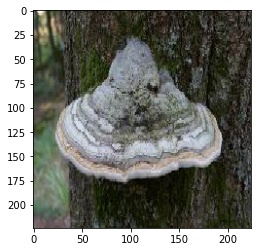

Probabilité pour les 4 classes : [[1.5772888e-01 3.0050879e-02 7.1214593e-04 1.7846240e-05 5.5689034e-06
  9.6254103e-04 3.0617232e-03 8.2154456e-06 3.2123603e-02 1.3522025e-04
  5.7582334e-03 3.7871795e-03 8.8004686e-04 3.7315115e-03 1.9259920e-03
  9.8108705e-03 1.0530503e-02 1.2306656e-02 2.7011072e-02 5.6961435e-03
  6.6635637e-03 2.3770139e-03 1.3135650e-02 4.5752112e-02 9.2340996e-03
  8.9150609e-04 1.4506833e-02 2.2471637e-05 8.1500867e-03 5.5223978e-01
  2.2778902e-04 1.3784220e-02 2.6324462e-02 8.8007793e-05 3.1583145e-04
  1.2524985e-06 2.0004964e-06 2.2209060e-06 8.3217208e-07 2.8277325e-06
  6.5892851e-07 2.0184355e-06 5.0331505e-07 1.0933700e-06 2.3556329e-06
  7.6040214e-07 2.4003461e-06 1.7834033e-06 2.9210258e-07 3.3649785e-06
  1.0585669e-06 1.0253340e-06 1.9513429e-06 2.1904477e-06 9.2258813e-07
  1.0460386e-06 1.4191287e-06 1.8333216e-06 3.3836818e-06 9.9419344e-07
  2.3606914e-07 7.1993009e-07 1.2757864e-07 5.3167508e-07]]
Classe présentie : Porotheleaceae


In [26]:
# Test prédiction 1

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('./Images/test/Polyporaceae/Fomes fomentarius32211.jpg',target_size=(224,224))
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])

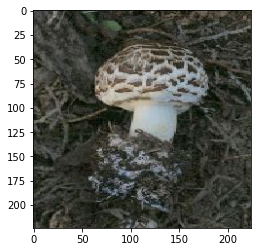

Probabilité pour les 4 classes : [[4.0330604e-01 2.8063363e-01 9.7061796e-03 2.2409415e-05 2.6895364e-06
  8.8654581e-04 2.3173902e-02 2.3758299e-05 2.3289165e-04 2.6505359e-05
  5.2423342e-03 1.9857637e-03 7.1537523e-03 1.4839945e-02 1.7824411e-02
  6.2772264e-03 6.1103152e-03 4.2163185e-03 4.2990227e-03 2.4392498e-04
  5.7137851e-03 2.6136759e-04 2.2238322e-02 4.0387814e-03 4.1615516e-02
  1.0317773e-04 3.3740290e-02 3.1252457e-05 4.7939375e-05 7.8582269e-04
  3.6834826e-05 5.7905193e-02 4.6523616e-02 4.6601190e-04 2.2468231e-04
  1.4622544e-06 1.1064108e-06 4.6214504e-06 8.9498167e-07 3.7992836e-06
  1.1689806e-06 1.8871832e-06 1.3199589e-06 1.8107252e-06 3.1505788e-06
  7.0687082e-07 2.1958181e-06 3.7219522e-06 6.1850068e-07 4.3200653e-06
  2.1030417e-06 2.0817859e-06 3.1323636e-06 1.7520751e-06 1.8041785e-06
  1.5109708e-06 3.2970677e-06 2.5471036e-06 3.3170854e-06 1.7206596e-06
  5.0143393e-07 1.2007650e-06 5.7205017e-07 1.5872063e-06]]
Classe présentie : Hygrophoraceae


In [27]:
# Test prédiction 2

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('./Images/test/Agaricaceae/Chlorophyllum brunneum1866.jpg',target_size=(224,224))
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])

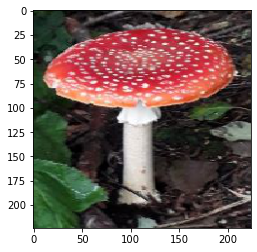

Probabilité pour les 4 classes : [[3.6559887e-03 9.5227849e-01 3.6128527e-03 5.0947119e-08 7.7487927e-09
  5.5316873e-06 2.2198053e-03 5.7679468e-08 3.2133127e-07 1.3825261e-08
  3.5758392e-04 3.1379037e-05 1.3338527e-04 4.7199004e-03 1.7154086e-03
  1.9153371e-04 7.7448376e-06 8.3243771e-04 2.8828920e-03 2.9544043e-07
  5.3975976e-04 3.0643869e-07 3.5946548e-03 2.7582841e-05 1.2776923e-03
  6.7098921e-07 1.4182541e-03 1.2518035e-08 2.5457567e-08 7.6766337e-06
  8.9640380e-08 1.9663714e-02 6.8258255e-04 1.3918077e-04 1.9973418e-06
  2.2547004e-09 4.2394173e-09 2.0684936e-08 1.2684612e-09 1.4000881e-08
  2.7491760e-09 2.3573653e-08 1.1084395e-09 4.9915205e-09 5.8632810e-09
  2.9913714e-09 2.3640145e-09 8.1993559e-09 5.3038651e-10 1.1941284e-08
  4.3844484e-09 3.8145678e-09 9.9683009e-09 6.4903825e-09 9.8788107e-09
  3.9972359e-09 5.4473412e-09 2.6266465e-09 1.1859933e-08 3.0380960e-09
  8.7915208e-10 1.1250062e-09 2.6152178e-10 1.2922144e-09]]
Classe présentie : Mycenaceae


In [28]:
# Test prédiction 3

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('./Images/test/Amanitaceae/Amanita muscaria14770.jpg',target_size=(224,224))
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])

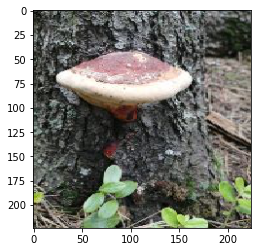

Probabilité pour les 4 classes : [[1.9729631e-01 2.4407835e-01 3.5216096e-03 1.9775322e-05 1.5961781e-06
  7.2285264e-05 3.0923091e-02 9.0368694e-06 5.5857563e-05 8.0285336e-06
  5.2122930e-03 3.9264369e-03 2.0390826e-03 9.0272333e-03 3.8860772e-02
  1.3521062e-02 1.3367192e-02 2.6869380e-03 3.0192544e-03 7.3371164e-05
  8.7380148e-03 1.2631337e-04 3.7531223e-02 2.2601776e-02 8.8235036e-02
  1.3798437e-05 1.4432485e-02 1.8567509e-05 1.7227661e-05 4.2764854e-04
  1.7040973e-05 1.3283312e-01 1.2701906e-01 2.1842493e-04 2.1076072e-05
  6.9124434e-07 5.0510914e-07 2.2792417e-06 4.1826482e-07 2.1694773e-06
  6.6250374e-07 8.1125376e-07 4.5612268e-07 8.6089932e-07 1.5474687e-06
  2.0748961e-07 8.8193548e-07 1.4746601e-06 1.4656652e-07 1.6983321e-06
  9.4685026e-07 1.2501679e-06 1.3486608e-06 7.6139986e-07 1.5321176e-06
  5.5020320e-07 1.3028620e-06 8.8002241e-07 3.2960852e-06 9.6413771e-07
  2.5607108e-07 5.9413696e-07 2.4983905e-07 9.7255065e-07]]
Classe présentie : Mycenaceae


In [29]:
# Test prédiction 4

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('./Images/test/Fomitopsidaceae/Fomitopsis pinicola802.jpg',target_size=(224,224))
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])